In [1]:
from __future__ import print_function # retain python 2 compatibility
import math
import ROOT
import numpy as np
from roc_tools import hists_to_roc, make_roc_plot

Welcome to JupyROOT 6.30/04


In [2]:
base_dir = '/eos/cms/store/user/fengwang/CMSDAS2024/' # if you're running from swan.cern.ch
tau_sample = f'{base_dir}/ztt_10_6_14.root'
jet_sample = f'{base_dir}/qcd_10_6_14.root'
tau_file = ROOT.TFile.Open(tau_sample)
tau_tree = tau_file.Get('per_tau')
jet_file = ROOT.TFile.Open(jet_sample)
jet_tree = jet_file.Get('per_tau')

In [3]:
base_selection = 'tau_decayModeFindingNewDMs && tau_pt>20. && abs(tau_eta)<2.3'
base_selection += '&& tau_dm != 5 && tau_dm != 6'

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false
}

<IPython.core.display.Javascript object>

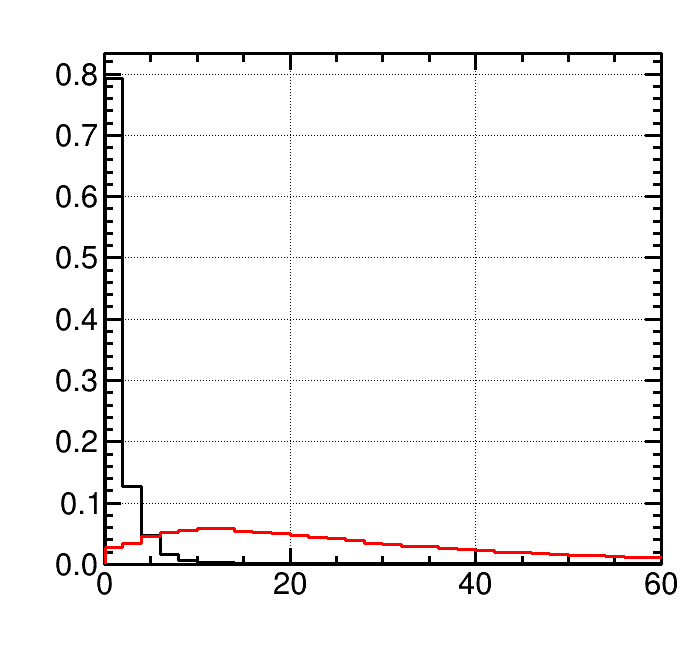

In [5]:
cv = ROOT.TCanvas()
h_ch_s = ROOT.TH1F('h_ch_s', '', 30, 0., 60.)
tau_tree.Project('h_ch_s', 'tau_chargedIsoPtSum', base_selection)
h_ch_b = ROOT.TH1F('h_ch_b', '', 30, 0., 60.)
jet_tree.Project('h_ch_b', 'tau_chargedIsoPtSum', base_selection)
h_ch_s.DrawNormalized()
h_ch_s.GetXaxis().SetTitle('charged isolation p_{T} sum [GeV]')
h_ch_b.SetLineColor(2)
h_ch_b.DrawNormalized("same")
cv.Draw()

In [6]:
print([g.GetName() for g in tau_tree.GetListOfBranches()])

['tau_eventid', 'tau_id', 'tau_dm', 'tau_pt', 'tau_eta', 'tau_phi', 'tau_mass', 'tau_chargedpt', 'tau_neutralpt', 'tau_gendm', 'tau_genpt', 'tau_geneta', 'tau_genphi', 'tau_genchargedpt', 'tau_genneutralpt', 'tau_vertex', 'tau_nTruePU', 'tau_nPU', 'tau_tauVtxTovtx_dz', 'tau_iso_dz001', 'tau_iso_dz02', 'tau_iso_pv', 'tau_iso_nopv', 'tau_iso_neu', 'tau_iso_puppi', 'tau_iso_puppiNoL', 'tau_dxy', 'tau_dxy_err', 'tau_dxy_sig', 'tau_ip3d', 'tau_ip3d_err', 'tau_ip3d_sig', 'tau_flightLength', 'tau_flightLength_sig', 'tau_byCombinedIsolationDeltaBetaCorrRaw3Hits', 'tau_byLooseCombinedIsolationDeltaBetaCorr3Hits', 'tau_byMediumCombinedIsolationDeltaBetaCorr3Hits', 'tau_byTightCombinedIsolationDeltaBetaCorr3Hits', 'tau_byIsolationMVArun2v1DBoldDMwLTraw', 'tau_byVVLooseIsolationMVArun2v1DBoldDMwLT', 'tau_byVLooseIsolationMVArun2v1DBoldDMwLT', 'tau_byLooseIsolationMVArun2v1DBoldDMwLT', 'tau_byMediumIsolationMVArun2v1DBoldDMwLT', 'tau_byTightIsolationMVArun2v1DBoldDMwLT', 'tau_byVTightIsolationMVAru

In [7]:
signal = ROOT.TH1F('signal', '', 1000, 0., 1.0001)
background = ROOT.TH1F('background', '', 1000, 0., 1.0001)

tau_tree.Project('signal', '1./(1.+tau_chargedIsoPtSum)', base_selection)
jet_tree.Project('background', '1./(1.+tau_chargedIsoPtSum)', base_selection)

43847

In [8]:
roc = hists_to_roc(signal, background)
roc.title = 'charged'

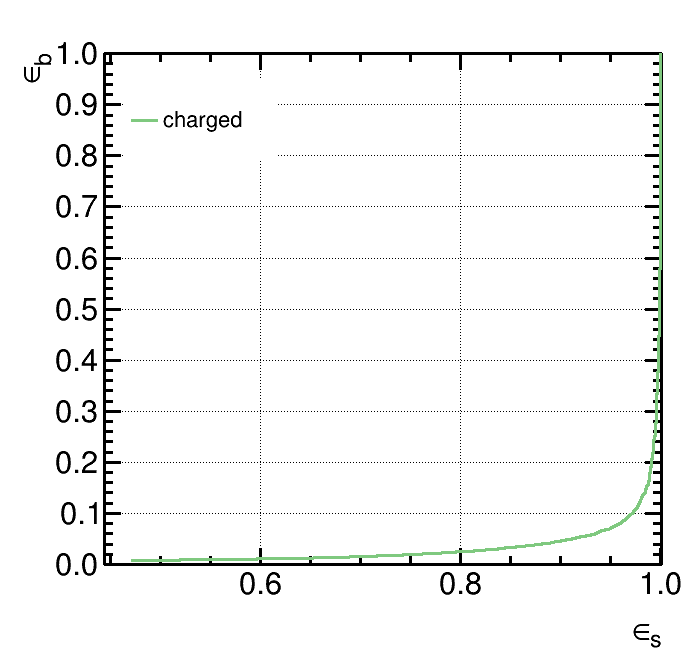

In [9]:
_, canvas = make_roc_plot([roc])
canvas.Draw()

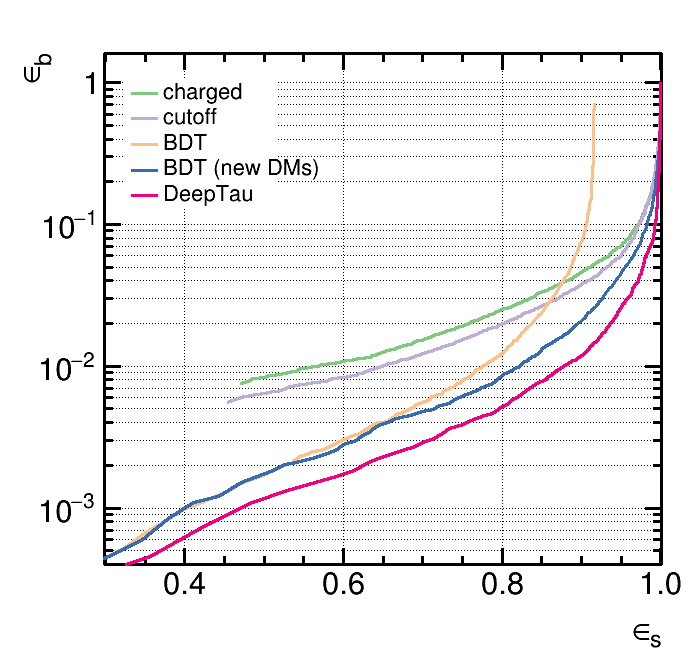

In [10]:
discriminators = {
    'tau_chargedIsoPtSum':'charged', 
    # cutoff-based tau isolation, used in run 1, e.g. in TAU-14-001 and HIG-13-004
    'tau_byCombinedIsolationDeltaBetaCorrRaw3Hits':'cutoff', 
    # BDT-based tau ID, started in TAU-14-001 and refined in TAU-16-003
    'tau_byIsolationMVArun2v1DBoldDMwLTraw':'BDT', 
    # BDT-based tau ID, started in TAU-14-001 and refined in TAU-16-003
    'tau_byIsolationMVArun2v1DBnewDMwLTraw':'BDT (new DMs)', 
    # New DNN-based ID
    'tau_byDeepTau2017v2VSjetraw':'DeepTau'
}
rocs = []
for disc, title in discriminators.items():
    s_name = 'signal'+disc
    b_name = 'background'+disc
    signal = ROOT.TH1F(s_name, '', 1000, 0., 1.0001)
    background = ROOT.TH1F(b_name, '', 1000, 0., 1.0001)
    # The BDT values lie in the range [-1, 1] so we transform x -> 1./(2+x)
    # to make sure outputs lie in the range [0, 1]
    tau_tree.Project(s_name, f'1./(2.+{disc})', base_selection)
    jet_tree.Project(b_name, f'1./(2.+{disc})', base_selection)
    roc = hists_to_roc(signal, background)
    roc.title = title
    rocs.append(roc)
_, m_canvas = make_roc_plot(rocs, xmin=0.3, ymin=0.0001, ymax=0., logy=True)
m_canvas.Draw()

In [11]:
muo_sample = f'{base_dir}/zmm_10_6_14.root'
ele_sample = f'{base_dir}/zee_10_6_14.root'
muo_file = ROOT.TFile.Open(muo_sample)
muo_tree = muo_file.Get('per_tau')
ele_file = ROOT.TFile.Open(ele_sample)
ele_tree = ele_file.Get('per_tau')

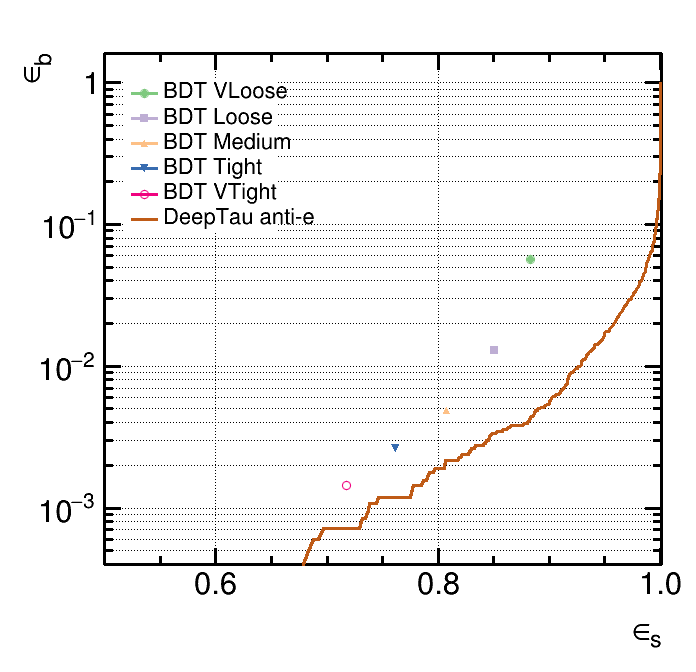

In [12]:
discriminators = {
    '(tau_againstElectronVLooseMVA6)':'BDT VLoose',
    '(tau_againstElectronLooseMVA6)':'BDT Loose', 
    '(tau_againstElectronMediumMVA6)':'BDT Medium', 
    '(tau_againstElectronTightMVA6)':'BDT Tight', 
    '(tau_againstElectronVTightMVA6)':'BDT VTight', 
    'tau_byDeepTau2017v2VSeraw':'DeepTau anti-e', 
}
rocs = []
base_selection = 'tau_decayModeFinding && tau_pt>20. && abs(tau_eta)<2.3'
for disc, title in discriminators.items():
    s_name = 'signal'+title
    b_name = 'background'+title
    signal = ROOT.TH1F(s_name, '', 10000, 0., 1.0001)
    background = ROOT.TH1F(b_name, '', 10000, 0., 1.0001)
    draw_expr = f'1./(2.+{disc})'
    tau_tree.Project(s_name, draw_expr, base_selection)
    ele_tree.Project(b_name, draw_expr, base_selection)
    roc = hists_to_roc(signal, background)
    roc.title = title
    rocs.append(roc)
_, m_canvas = make_roc_plot(rocs, xmin=0.5, ymin=0.0001, ymax=0., logy=True)
m_canvas.Draw()

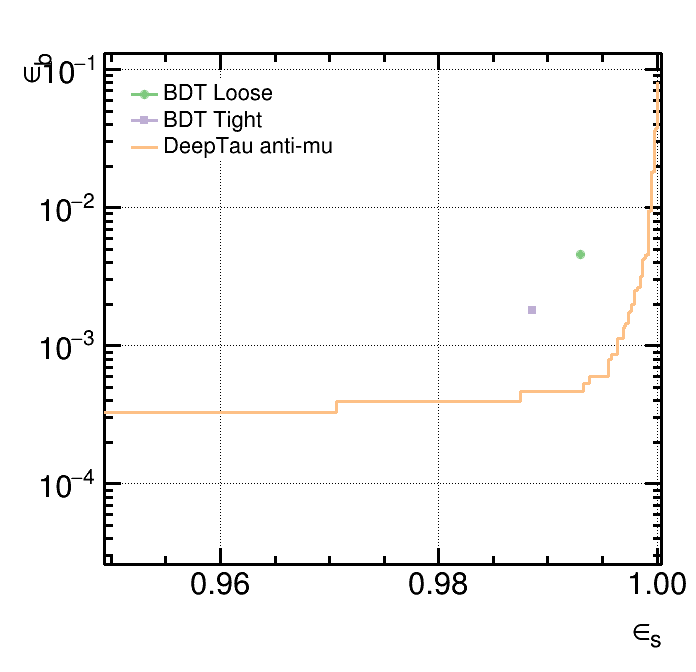

In [13]:
discriminators = {
    '(tau_againstMuonLoose3)':'BDT Loose', 
    '(tau_againstMuonTight3)':'BDT Tight', 
    'tau_byDeepTau2017v2VSmuraw':'DeepTau anti-mu', 
}
rocs = []
base_selection = 'tau_decayModeFinding && tau_pt>20. && abs(tau_eta)<2.3'
for disc, title in discriminators.items():
    s_name = 'signal'+title
    b_name = 'background'+title
    signal = ROOT.TH1F(s_name, '', 10000, 0., 1.0001)
    background = ROOT.TH1F(b_name, '', 10000, 0., 1.0001)
    draw_expr = f'1./(2.+{disc})'
    tau_tree.Project(s_name, draw_expr, base_selection)
    muo_tree.Project(b_name, draw_expr, base_selection)
    roc = hists_to_roc(signal, background)
    roc.title = title
    rocs.append(roc)
_, m_canvas = make_roc_plot(rocs, xmin=0.95, ymin=0.0001, ymax=0., logy=True)
m_canvas.Draw()